In [1]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [11]:
searchfor = '.h5'
searchdir = 'data/lakes/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]

In [12]:
thresh_upper = 1.005
thresh_lower = -5.505

df_list = []

# for i,fn in enumerate(filelist[:10]):
for i,fn in enumerate(filelist):
    
    print('reading file %5i / %5i' % (i+1, len(filelist)), end='\r')

    lk = read_melt_lake_h5(fn)
    df = lk['photon_data']
    is_saturated = df.sat_ratio >= 1.0
    frac_sat = np.sum(is_saturated) / len(df)
    dfs = df[(df.sat_ratio >= 1.0)].copy()
    dfs['h_relative_to_saturated_peak'] = dfs.h - dfs.sat_elev
    dfs = dfs[(dfs.h_relative_to_saturated_peak >= thresh_lower-0.1) & (dfs.h_relative_to_saturated_peak <= thresh_upper+0.1)]
    
    dfs['surface_elevation'] = lk['surface_elevation']
    dfs['beam_strength'] =  lk['beam_strength']
    dfs['beam_number'] = lk['beam_number']
    dfs['gtx'] = lk['gtx']
    dfs['lake_nr'] = i
    
    dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    dfs['quality'] = lk['quality_summary']
    dfs['frac_sat'] = frac_sat
    dfs.reset_index(inplace=True, drop=True)
    dfs['ph_index'] = dfs.index
    dfs['fn'] = fn

    df_list.append(dfs)

In [13]:
dfs_all = pd.concat(df_list)
dfs_all = dfs_all.rename(columns={'sat_ratio': 'ratio_saturation'})
dfs_all['is_saturated'] = dfs_all.ratio_saturation >= 1.0

In [14]:
thresh_upper = 1.005
thresh_lower = -5.505

peak_target_elevs = [0.0, -0.56, -0.93, -1.47, -1.85, -2.44, -4.25]
widths_pk = [0.0, 0.3, 0.225, 0.225, 0.225, 0.35, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']

def make_saturation_plot(dfs, beam_select='all', ax=None):
    if type(beam_select) == np.int64:
        dfs = dfs[dfs_all.beam_number == beam_select]
    elif 'gt' in beam_select:
        dfs = dfs[dfs_all.gtx == beam_select]
    elif beam_select == 'all':
        dfs = dfs
    else:
        dfs = dfs[dfs_all.beam_strength == beam_select]
    n_lakes = len(np.unique(dfs.lake_nr))
    print('There are %i lakes for the following beam selection: "%s"' % (n_lakes, beam_select))

    df_issat = dfs[dfs.is_saturated]

    bin_h = 0.01
    smooth_h_top = 0.05
    smooth_h_middle = 0.1
    smooth_h_bottom = 0.2
    switch1 = -1.2
    switch2 = -2.1
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth_top = int(np.round(smooth_h_top/bin_h))
    smooth_middle = int(np.round(smooth_h_middle/bin_h))
    smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
    histweights = np.array(dfs_all.ratio_saturation).astype(np.float64)
    hist_h = np.histogram(np.array(dfs_all.h_relative_to_saturated_peak).astype(np.float64), bins=bins, weights=histweights)
    hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
    hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
    hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
    seg1 = hist_h_smooth_bottom[mids<=switch2]
    seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
    seg3 = hist_h_smooth_top[mids>switch1]
    hist_h_smooth = np.concatenate((seg1, seg2, seg3))
    hist_h_full = hist_h[0] / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    
    if not ax:
        fig, ax = plt.subplots(figsize=[6, 6], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax = (1e-5,10)
    
    style = 'k:' if beam_select == 'weak' else 'k-'
    ax.plot(hist_h_smooth, mids, style, lw=1)
    ax.scatter(hist_h_full, mids, s=1, c='k', alpha=0.1)
    for i in range(len(peak_target_elevs)):
        thish = peak_target_elevs[i]
        thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thish))]
        ax.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=-1000)
        if i == 0:
            ax.text(1.1*xlim_ax[0], thish, 'saturated surface return', color=cols_pk[i], ha='left', va='bottom', fontsize=9)
        else:
            ax.text(thispeak_height, thish, r'%.2f m' % thish, color=cols_pk[i], weight='bold', va='center', fontsize=10)
    
    ax.set_xlabel('normalized photon counts')
    ax.set_ylabel('elevation relative to saturated surface return')
    ax.set_xlim(xlim_ax)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    return mids, hist_h_full, hist_h_smooth
    

There are 1001 lakes for the following beam selection: "all"
There are 517 lakes for the following beam selection: "strong"
There are 484 lakes for the following beam selection: "weak"
There are 178 lakes for the following beam selection: "1"
There are 158 lakes for the following beam selection: "2"
There are 180 lakes for the following beam selection: "3"
There are 174 lakes for the following beam selection: "4"
There are 159 lakes for the following beam selection: "5"
There are 152 lakes for the following beam selection: "6"


,elev_bins,counts_all,smooth_all,counts_strong,smooth_strong,counts_weak,smooth_weak,counts_1,smooth_1,counts_2,smooth_2,counts_3,smooth_3,counts_4,smooth_4,counts_5,smooth_5,counts_6,smooth_6
0,-5.50,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648,0.001654,0.001648
1,-5.49,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658,0.001721,0.001658
2,-5.48,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669,0.001504,0.001669
3,-5.47,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678,0.001706,0.001678
4,-5.46,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678,0.001568,0.001678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,0.95,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488,0.000482,0.000488
646,0.96,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467,0.000430,0.000467
647,0.97,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448,0.000455,0.000448
648,0.98,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439,0.000448,0.000439


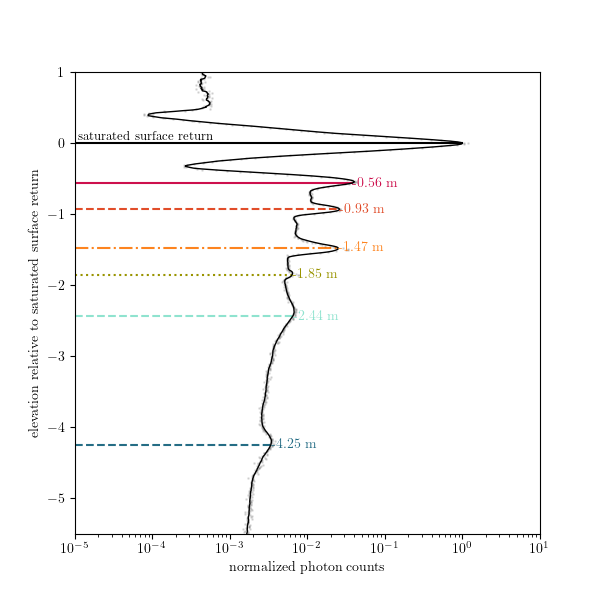

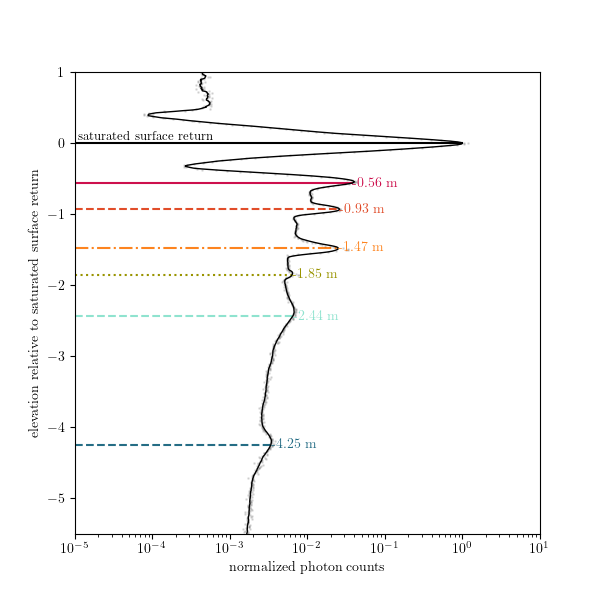

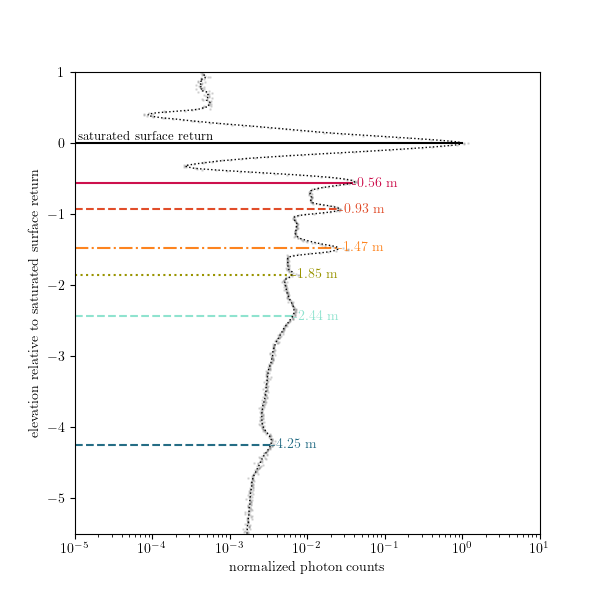

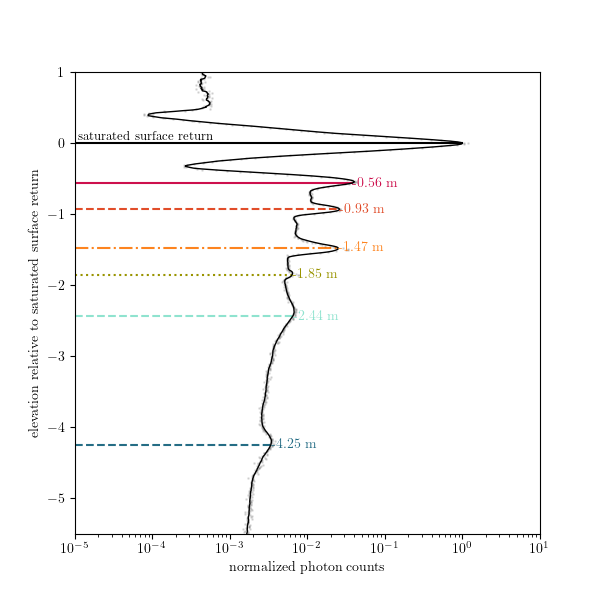

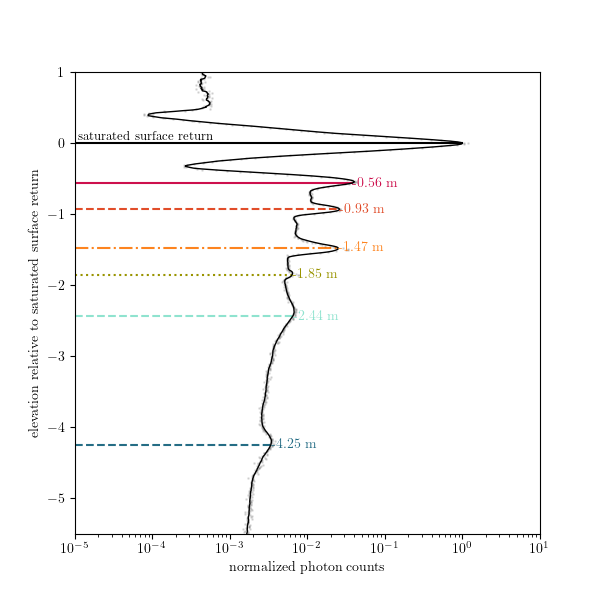

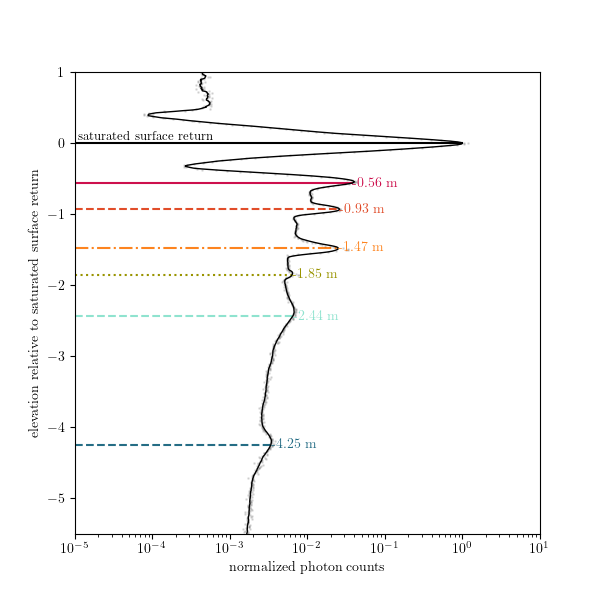

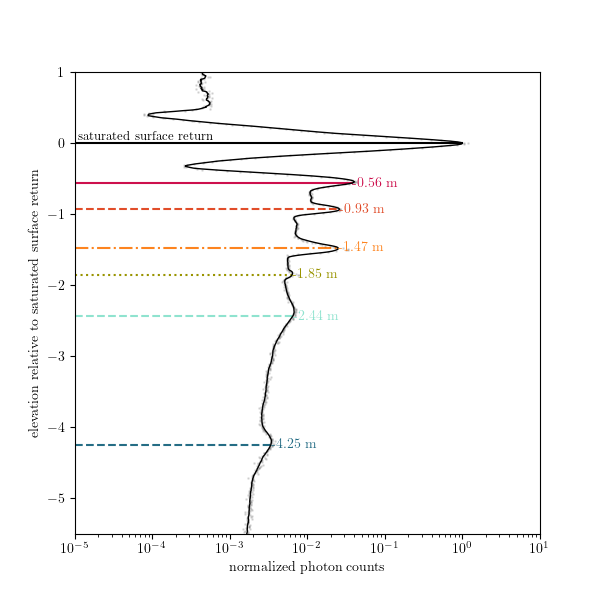

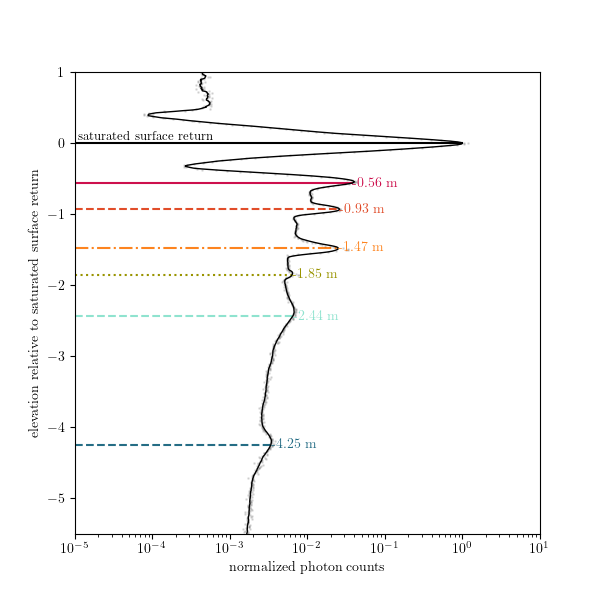

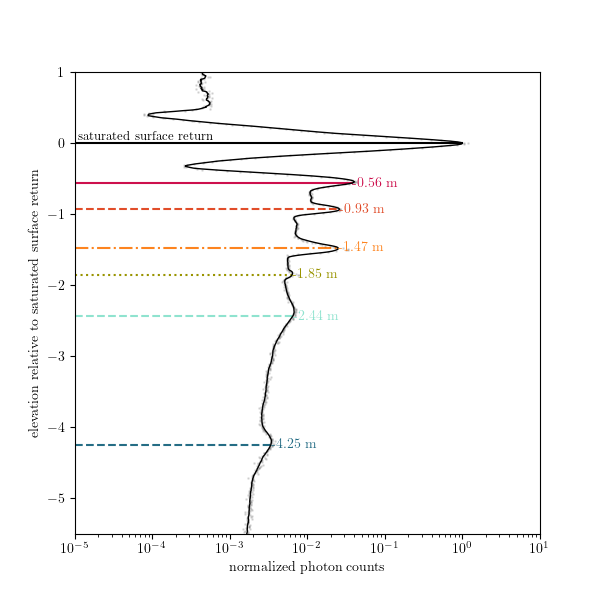

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
# for i, beam_select in enumerate(['all', 'strong']):
    mids, hist_full, hist_smooth = make_saturation_plot(dfs_all, beam_select=beam_select)
    if i == 0:
        df = pd.DataFrame({'elev_bins': mids})
    df['counts_%s'%beam_select] = hist_full
    df['smooth_%s'%beam_select] = hist_smooth
    
df.to_csv('data/saturation_counts_methodsdata.csv', index=False)
df

In [16]:
dfs_all.to_pickle('data/saturated_pulses_data.pkl')